# Kickstarter Predictions

Kickstarter serves as a prominent platform for crowdfunding, fostering innovation by connecting creators with potential backers. The success or failure of projects on Kickstarter depends on various factors, and this dataset offers a comprehensive exploration of these dynamics.

### Dataset Overview

The dataset encompasses 370k Kickstarter projects spanning the years 2009 to 2018, covering regions such as North America, Japan, Europe, and Australia. Key attributes include project details (ID, Name, Category, Subcategory), launch information (Country, Launch Date, Deadline), financial aspects (Goal, Pledged, Backers), and the project's final state (State).

### Objectives

#### Understanding Kickstarter Landscape
- **Analysis Scope:** Explore the Kickstarter landscape, categorizing projects and investigating the interplay of variables influencing project outcomes.
- **Beneficiaries:** Researchers, analysts, and stakeholders seeking insights into crowdfunding dynamics and factors influencing project success or failure.

#### Task & Business Cases

The primary focus is on catering to the needs of campaign creators, enhancing their Kickstarter experience, and indirectly benefiting backers and Kickstarter itself.

##### Business Questions for Creators
1. **Campaign Success Prediction:** Can we predict the success of a campaign based on factors such as category, launch date, duration, and funding goal?
2. **Backer Estimation:** Can we estimate the number of backers a campaign needs to attract, considering launch date, duration, and funding goal?

### The Data Dictionary

| Column        | Description                                                   |
|---------------|---------------------------------------------------------------|
| `ID`          | Project ID on Kickstarter                                     |
| `Name`        | Project Name on Kickstarter                                   |
| `Category`    | Project Category (Music, Film & Video, ...)                   |
| `Subcategory` | Project Subcategory (Rock, Pop, ...)                          |
| `Country`     | Country of Project/Product Origin                             |
| `Launched`    | Date of Project Launch                                        |
| `Deadline`    | Deadline for Crowd Funding                                    |
| `Goal`        | Amount of Money Needed for Creator to Complete Project in USD |
| `Pledged`     | Amount of Money That Was Pledged/Collected in USD             |
| `Backers`     | Amount of People That Pledged                                 |
| `State`       | State of Completion/Success                                   |

#### Acknowledgements
This dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/ulrikthygepedersen/kickstarter-projects/data), and we extend our gratitude to [Ulrik Thyge Pedersen](https://www.kaggle.com/ulrikthygepedersen) for curating and sharing this valuable dataset. 

## Let's get started our PRRRRRRRRRRREDICTION!

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.preprocessing import OneHotEncoder, RobustScaler, power_transform, PowerTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

from xgboost import XGBClassifier, XGBRegressor


#### Load the dataset

In [2]:
# import data from CSV after downloading from Kaggle 
# https://www.kaggle.com/datasets/ulrikthygepedersen/kickstarter-projects/
df = pd.read_csv('../data/kickstarter_projects.csv')

### 1. Data Exploration

In [3]:
df.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


In [4]:
print('The original data has', df.shape[0],'rows and', df.shape[1], 'columns.')

The original data has 374853 rows and 11 columns.


In [5]:
nans = df.isna().sum()
print(len(nans[nans > 0]), 'columns have missing values.')

0 columns have missing values.


In [6]:
df.info()
### We can see that none of the columns have null values, which is great. The datatypes are also correct, 
### except for the 'deadline' and 'launched' columns. We will convert these to datetime objects.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB


In [7]:
print(df.duplicated().sum(), 'rows are duplicated.')
print(df['ID'].duplicated().sum(), 'IDs are duplicated.')
### No entire rows are duplicated, and no project appears twice in the data.

0 rows are duplicated.
0 IDs are duplicated.


In [8]:
df[['Goal', 'Pledged', 'Backers']].describe().T
### We can see that 'Goal' has a minimum value of 0, which is curious. Further investigation is needed.
### All $ columns have a large range, so we likely are dealing with outliers and need scaling later on. Some $ columns have 0s
### which is expected.

,count,mean,std,min,25%,50%,75%,max
Goal,374853.0,45863.784796,1.158778e+06,0.0,2000.0,5500.0,16000.0,166361391.0
Pledged,374853.0,9121.072719,9.132054e+04,0.0,31.0,625.0,4051.0,20338986.0
Backers,374853.0,106.690359,9.117185e+02,0.0,2.0,12.0,57.0,219382.0


The data frame has no missing values or duplicated rows/projects. We observed that numeric columns have a large range, which assumes scaling of the feature later on. All data types are appropriate with two exceptions `deadline` and `launched`. They will be transformed subsequently. We also found 0 values in the feature `Goal`, which needs more exploration.

### 2. Data Preprocessing

In [9]:
import datetime as dt

# Convert 'deadline' and 'launched' to datetime objects
df['Deadline'] = pd.to_datetime(df['Deadline'])
df['Launched'] = pd.to_datetime(df['Launched'])


In [10]:
# Create new column 'Duration' which is the difference between 'Deadline' and 'Launched'
# Will be interesting to see if this has any correlation with success and other metrics.
df['Duration'] = (df['Deadline'] - df['Launched']).dt.days

# split launchdate and deadline into year, month, day, day of week
df['LaunchYear'] = df['Launched'].dt.year
df['LaunchMonth'] = df['Launched'].dt.month
df['LaunchDay'] = df['Launched'].dt.day
df['LaunchDayOfWeek'] = df['Launched'].dt.dayofweek

df['DeadlineYear'] = df['Deadline'].dt.year
df['DeadlineMonth'] = df['Deadline'].dt.month
df['DeadlineDay'] = df['Deadline'].dt.day
df['DeadlineDayOfWeek'] = df['Deadline'].dt.dayofweek

df.drop(columns=['Launched', 'Deadline'], inplace=True)

### 3. Exploratory Data Analysis

#### Assumptions

In our exploration of the Kickstarter dataset, we make several assumptions to guide our analysis and derive meaningful insights:

1. **Optimal Goal Determination:**
   We assume that within the dataset, there exists an optimal funding goal that correlates with project success. This assumption prompts us to investigate the relationship between funding goals and the likelihood of achieving campaign success.

2. **Influence of Launch Times/Dates:**
   It is presumed that specific launch times and dates contribute to the success of a Kickstarter campaign. Our analysis will focus on uncovering patterns and trends related to the temporal aspects of project launches.

3. **Category/Subcategory Impact:**
   We assume that certain combinations of project categories and subcategories play a significant role in determining the success of Kickstarter projects. Our investigation aims to identify and understand these combinations, shedding light on which categories/subcategories are more likely to achieve success.

   - *Note: Further analysis will validate or refute this assumption.*

4. **Campaign Duration Effect:**
   The belief is that an ideal campaign duration influences the probability of project success. Our exploration will delve into the relationship between campaign duration and the likelihood of achieving the desired funding.

5. **Evolution of Success Over Time:**
   An assumption is made that project success and Kickstarter success have evolved over time, with variations across different years. Our analysis will consider temporal changes to provide insights into the dynamic nature of Kickstarter success.

   - *Note: The analysis will assess trends and patterns across different years to substantiate this assumption.*


#### State Column

There are 5 different labels in the `State` column: 'Failed', 'Successful', 'Canceled', 'Suspended', 'Live' and we need to understand their meaning and further define what successful campagnes acutally mean.

In [11]:
print('Value Counts for State:')
print(pd.DataFrame(df.State.value_counts()))

print('Percentage of Total for State:')
print(pd.DataFrame(round(df.State.value_counts()/len(df)*100, 2)))

Value Counts for State:
             count
State             
Failed      197611
Successful  133851
Canceled     38751
Live          2798
Suspended     1842
Percentage of Total for State:
            count
State            
Failed      52.72
Successful  35.71
Canceled    10.34
Live         0.75
Suspended    0.49


#### State = Successful
DEFINITION: A successful project reached their goal (pledged >= goal) and has passed the deadline.

In [12]:
print('Number of successful projects:', \
      df[((df['State'] == 'Successful'))].shape[0])
print('% of Successful projects:', \
      round((df[((df['State'] == 'Successful'))].shape[0] / len(df))*100, 2), '%')


print('Number of Successful projects, where Goal was reached:', \
        df[((df['State'] == 'Successful') & (df['Pledged'] >= df['Goal']))].shape[0])
print('% of Successful projects, where Goal was reached:', \
      round((df[((df['State'] == 'Successful') & (df['Pledged'] >= df['Goal']))].shape[0] / \
        len(df[df['State'] == 'Successful'])*100), 2), '%')
print('Number of successful projects, where Goal was not reached:', \
        df[((df['State'] == 'Successful') & (df['Pledged'] < df['Goal']))].shape[0])


print('Average Duration of successful projects:', \
      round((df[((df['State'] == 'Successful'))]['Duration'].mean()), 0), 'days')
print('Number of Successful projects, where Duration is 0:', \
      df[((df['State'] == 'Successful') & (df['Duration'] == 0))].shape[0])
print('Number of Successful projects, where Duration and Goal is 0:', \
      df[((df['State'] == 'Successful') & (df['Duration'] == 0) & (df['Goal'] == 0))].shape[0])
print('Number of Successful projects, where Goal is 0:', \
      df[((df['State'] == 'Successful') & (df['Goal'] == 0))].shape[0])

Number of successful projects: 133851
% of Successful projects: 35.71 %
Number of Successful projects, where Goal was reached: 133849
% of Successful projects, where Goal was reached: 100.0 %
Number of successful projects, where Goal was not reached: 2
Average Duration of successful projects: 31.0 days
Number of Successful projects, where Duration is 0: 35
Number of Successful projects, where Duration and Goal is 0: 1
Number of Successful projects, where Goal is 0: 2


Observations:
- **Campaign Success Rate:**
  Approximately 35% of campaigns in the dataset are marked as successful.

- **Anomalies in Successful Campaigns:**
  We identified two campaigns marked as successful, although they do not meet our definition of success (goal less than or equal to pledged). We hypothesize that at the time of the deadline, these campaigns may have initially reached their goal, but some payments may have fallen through, similar to failed observations. Despite this anomaly, due to the small number (only two), we have chosen to retain them in the successful category.

- **Campaigns with Unusual Goals:**
  - There is one campaign with a goal of 0 and a duration of 0. Further investigation revealed that the goal was denominated in Mx$ (Mexican pesos), and it was below 1 USD.
  - Another campaign has a goal of 0, and upon closer examination, we confirmed that the goal was indeed 0, but it still garnered pledges totaling 100 USD.

These observations highlight the intricacies and nuances present in the dataset, necessitating a careful consideration of outliers and anomalies during the analysis.


#### State = Failed
DEFINITION: A failed project has not reached their goal (pledged < goal) and has passed the deadline.

In [13]:
print('Number of Failed projects:', \
      df[((df['State'] == 'Failed'))].shape[0])
print('% of Failed projects:', \
      round((df[((df['State'] == 'Failed'))].shape[0] / len(df))*100, 2), '%')


print('Number of Failed projects, where Goal was reached:', \
        df[((df['State'] == 'Failed') & (df['Pledged'] >= df['Goal']))].shape[0])
print('% of Failed projects, where Goal was reached:', \
      round((df[((df['State'] == 'Failed') & (df['Pledged'] >= df['Goal']))].shape[0] / \
        len(df[df['State'] == 'Failed'])*100), 2), '%')
print('Number of Failed projects, where Goal was not reached:', \
        df[((df['State'] == 'Failed') & (df['Pledged'] < df['Goal']))].shape[0])


print('Average Duration of Failed projects:', \
      round((df[((df['State'] == 'Failed'))]['Duration'].mean()), 0), 'days')
print('Number of Failed projects, where Duration is 0:', \
      df[((df['State'] == 'Failed') & (df['Duration'] == 0))].shape[0])
print('Number of Failed projects, where Duration and Goal is 0:', \
      df[((df['State'] == 'Failed') & (df['Duration'] == 0) & (df['Goal'] == 0))].shape[0])
print('Number of Failed projects, where Goal is 0:', \
      df[((df['State'] == 'Failed') & (df['Goal'] == 0))].shape[0])

Number of Failed projects: 197611
% of Failed projects: 52.72 %
Number of Failed projects, where Goal was reached: 10
% of Failed projects, where Goal was reached: 0.01 %
Number of Failed projects, where Goal was not reached: 197601
Average Duration of Failed projects: 34.0 days
Number of Failed projects, where Duration is 0: 57
Number of Failed projects, where Duration and Goal is 0: 0
Number of Failed projects, where Goal is 0: 1


Observations:
- **Campaign Failure Rate:**
  Over 52% of campaigns in the dataset are anticipated to fail.

- **Anomalies in Failed Campaigns:**
  We identified 10 projects that reached their goal but were classified as failed. The discrepancy between the goal and pledged amounts is relatively small, constituting less than 10% of the goal. Our hypothesis is that, in some instances, projects can receive pledges after the deadline due to payment delays, such as credit card payments going through. As an illustrative example, consider [The new face of Canadian Science Fiction](https://www.kickstarter.com/projects/aescifi/the-new-face-of-canadian-science-fiction/?ref=kicktraq). Therefore, we have decided to consider these projects as successful.

These observations shed light on the complexities and nuances inherent in crowdfunding campaigns, prompting a careful consideration of factors beyond the initial campaign deadline.


#### State = Suspended
DEFINITION: A project can be suspended for various reasons. See more [here](https://help.kickstarter.com/hc/en-us/articles/115005136354-What-happens-when-a-project-is-suspended-).

In [14]:
print('Number of suspended projects:', \
      df[((df['State'] == 'Suspended'))].shape[0])
print('% of Suspended projects:', \
      round((df[((df['State'] == 'Suspended'))].shape[0] / len(df))*100, 2), '%')


print('Number of Suspended projects, where Goal was reached:', \
        df[((df['State'] == 'Suspended') & (df['Pledged'] >= df['Goal']))].shape[0])
print('% of Suspended projects, where Goal was reached:', \
      round((df[((df['State'] == 'Suspended') & (df['Pledged'] >= df['Goal']))].shape[0] / \
        len(df[df['State'] == 'Suspended'])*100), 2), '%')
print('Number of suspended projects, where Goal was not reached:', \
        df[((df['State'] == 'Suspended') & (df['Pledged'] < df['Goal']))].shape[0])


print('Top 10 suspended campaigns names by Goal:\n', \
      df[df['State'] == 'Suspended'].sort_values(by='Goal', ascending=False).head(10).Name.values)


Number of suspended projects: 1842
% of Suspended projects: 0.49 %
Number of Suspended projects, where Goal was reached: 292
% of Suspended projects, where Goal was reached: 15.85 %
Number of suspended projects, where Goal was not reached: 1550
Top 10 suspended campaigns names by Goal:
 ["Let's prove the earth is FLAT! (Suspended) (Suspended)"
 'Kickstarter 2 - We are Making a Better Kickstarter'
 'Wireless Typewriter (Suspended) (Suspended) (Suspended)'
 'Green Buffalo Estates (Suspended)'
 'Marvel vs Capcom resurrection!! (Suspended)'
 'The OC - Season Five (Suspended) (Suspended) (Suspended)'
 'YouLoox - Awesome Holographic Computer (Suspended)'
 'Make Fun Fun Fun Fest Great Again (Suspended)' "I'm in (Suspended)"
 'flucksus']


Observations:
- **Campaign Suspension Rate:**
  Less than 1% of campaigns in the dataset are marked as suspended.

- **Criteria for Campaign Suspension:**
  According to the [Kickstarter Help Center](https://help.kickstarter.com/hc/en-us/articles/115005136354-What-happens-when-a-project-is-suspended-), there are specific criteria set for suspending a campaign.

- **Prank Campaigns with Excessive Goals:**
  In examining the top 10 projects by goal, it is evident that most of the projects with extravagant goals are prank campaigns, exemplified by projects like `Kickstarter 2 - We are Making a Better Kickstarter`.

- **Data Cleaning Decision:**
  As a result of our analysis, we have made the decision to drop all suspended projects from our dataset.

These observations provide insights into the occurrence of suspended campaigns and the rationale behind the decision to exclude them from the analysis.


In [15]:
# drop all rows where state is 'suspended'
df = df[df['State'] != 'Suspended']

#### State = Live  
DEFINITION: We cannot give a full definition of "live" state. Our hunch is that the data was pulled several times and the "live" campaigns were ongoing at the time; we cannot fully verify this with the existing data.

In [16]:
print('Number of live projects:', \
      df[((df['State'] == 'Live'))].shape[0])
print('% of live projects:', \
      round((df[((df['State'] == 'Live'))].shape[0] / len(df))*100, 2), '%')


print('Number of live projects, where Goal was reached:', \
        df[((df['State'] == 'Live') & (df['Pledged'] >= df['Goal']))].shape[0])
print('Number of live projects, where Goal was not reached:', \
        df[((df['State'] == 'Live') & (df['Pledged'] < df['Goal']))].shape[0])
print('% of live projects where Goal was not reached of all projects:', \
      round((df[((df['State'] == 'Live') & (df['Pledged'] < df['Goal']))].shape[0] / \
        len(df)*100), 2), '%')

Number of live projects: 2798
% of live projects: 0.75 %
Number of live projects, where Goal was reached: 441
Number of live projects, where Goal was not reached: 2357
% of live projects where Goal was not reached of all projects: 0.63 %


Observations:  
- **Classification of "Live" Campaigns:**
  We observed that 441 campaigns categorized as "live" have successfully reached their goal. According to our definition of success, these campaigns would be classified as successful. However, due to the uncertain nature of the remaining "live" campaigns, we refrain from making assumptions about their outcomes.

- **Data Management Decision:**
  In light of our observations, we have decided to merge the 441 campaigns that reached their goal into the "successful" category. This decision incurs less than 1% data loss. The rationale behind this data management step is to streamline the classification and enhance the accuracy of our success criteria.

These observations guide our approach to handling campaigns labeled as "live" and contribute to the refinement of our dataset for further analysis.


In [17]:
# drop rows where state is live and pledged is less than goal
df = df[~((df['State'] == 'Live') & (df['Pledged'] < df['Goal']))]

#### State = Canceled  
DEFINITION: According to the [Kickstarter Help Center](https://help.kickstarter.com/hc/en-us/articles/115005138393-How-can-I-cancel-my-project-), cancelations happen mostly due to changes in the campaign duration or moving the goal. Campaigns are canceled by the creator.

In [18]:
print('Number of canceled projects:', \
      df[((df['State'] == 'Canceled'))].shape[0])
print('% of canceled projects:', \
      round((df[((df['State'] == 'Canceled'))].shape[0] / len(df))*100, 2), '%')


print('Number of canceled projects, where Goal was reached:', \
        df[((df['State'] == 'Canceled') & (df['Pledged'] >= df['Goal']))].shape[0])
print('% of canceled projects where Goal was reached of all canceled projects:', \
      round((df[((df['State'] == 'Canceled') & (df['Pledged'] >= df['Goal']))].shape[0] / \
        len(df[df['State'] == 'Canceled'])*100), 2), '%')

Number of canceled projects: 38751
% of canceled projects: 10.45 %
Number of canceled projects, where Goal was reached: 698
% of canceled projects where Goal was reached of all canceled projects: 1.8 %


Observations:  
- **Cancellation Rate:**
  Approximately 10% of projects in the dataset are marked as canceled.

- **Cancellation with Goal Attainment:**
  Within the subset of canceled projects, around 2% of them actually reached their funding goal before being canceled. This suggests a noteworthy occurrence where a small fraction of projects manage to secure the required funding but are ultimately canceled.

These observations underscore the prevalence of project cancellations and highlight the nuanced situations where projects attain their goals before the cancellation decision is made.


### Goal & Pledge

In [19]:
df.Goal.describe()

count    3.706540e+05
mean     4.504897e+04
std      1.127955e+06
min      0.000000e+00
25%      2.000000e+03
50%      5.500000e+03
75%      1.595700e+04
max      1.663614e+08
Name: Goal, dtype: float64

In [20]:
# Custom color and orange
custom_colour = (108/255, 84/255, 158/255)  # RGB(108, 84, 158)
orange = (255/255, 165/255, 0/255)  # RGB(255, 165, 0)

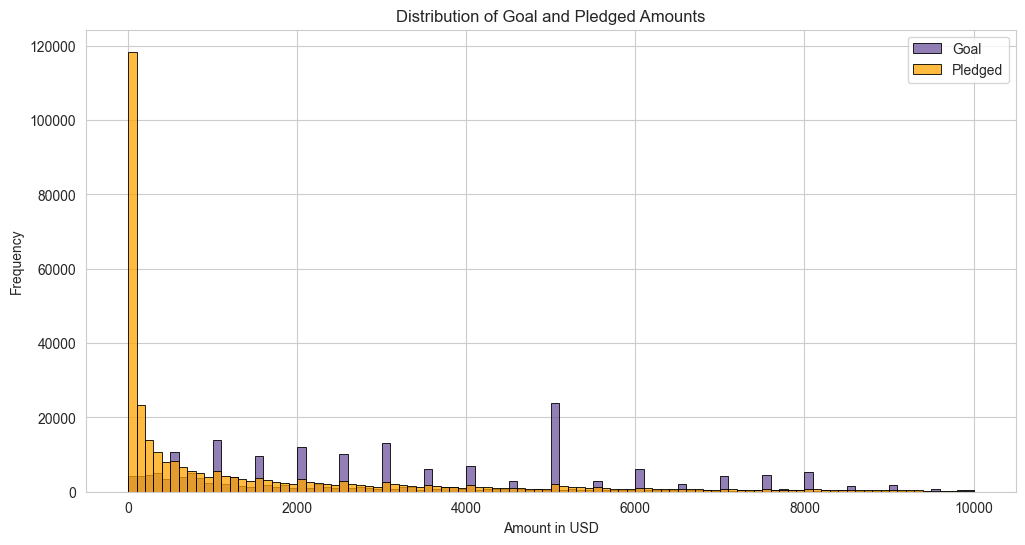

In [21]:
# Select relevant data
even = df#[df['Goal'] < df['Pledged']]
succonly = df #even[even['State'] == 'Successful']

# Plot histograms with custom colors
plt.figure(figsize=(12, 6))
sns.histplot(succonly[succonly['Goal'] < 10000], x='Goal', bins=100, color=custom_colour, edgecolor='black', label='Goal')
sns.histplot(succonly[succonly['Pledged'] < 10000], x='Pledged', bins=100, color=orange, edgecolor='black', label='Pledged')

# Customize the plot
plt.title('Distribution of Goal and Pledged Amounts')
plt.xlabel('Amount in USD')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Category/Subcategory

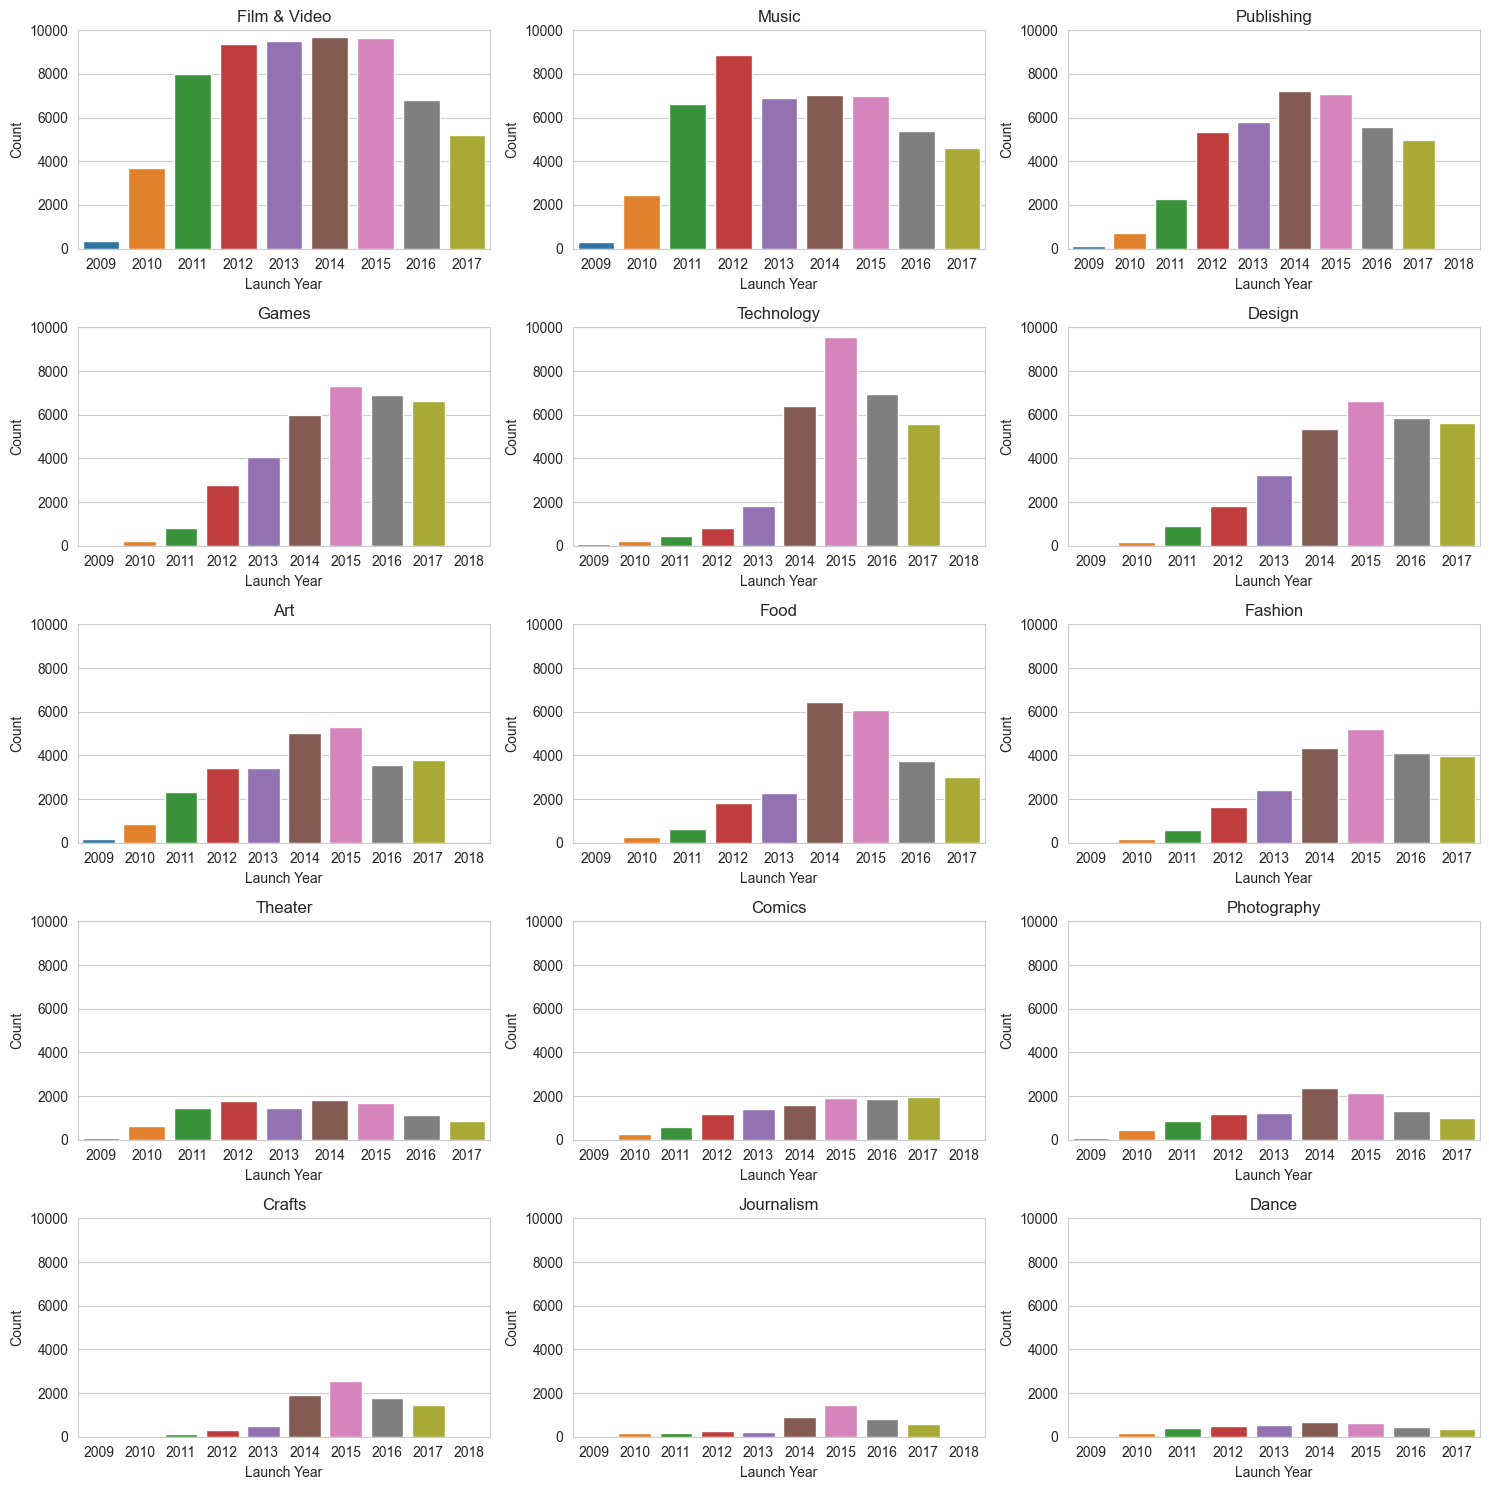

In [22]:
# Sort categories by total count
category_counts = df['Category'].value_counts()
sorted_categories = category_counts.index.tolist()

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Iterate over each category and create a countplot in the corresponding subplot
for i, category in enumerate(sorted_categories):
    # Calculate the row and column indices for the subplot
    row = i // 3
    col = i % 3

    # Select the subplot
    ax = axes[row, col]

    # Create a countplot for the specified category and state
    sns.countplot(data=df[(df['Category'] == category) #& (df['State'] == 'Successful')
                          ],
                  x='LaunchYear', ax=ax)

    # Set subplot title, x-axis label, y-axis label, and y-axis limit
    ax.set_title(category)
    ax.set_xlabel('Launch Year')
    ax.set_ylabel('Count')
    ax.set_ylim(0, 10000)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Observations:
- **Category Popularity Variation:**
  There is a notable discrepancy in the popularity of various categories, with some attracting significantly more projects than others.

- **Temporal Trends in Specific Categories:**
  - Film, Music, and Publishing enjoyed high popularity in the early years of Kickstarter, notably until 2013.
  - Film and Music categories experienced a plateau in popularity after 2013.
  - Most other categories observed a substantial surge around 2014/2015, coinciding with the peak of crowdfunding interest.
  
- **Post-2015 Decline Across Categories:**
  Following the peak years, a decline is evident across most categories after 2015. This decline could be attributed to increased competition in the crowdfunding space during this period.

These observations underscore the dynamic nature of category preferences and highlight the influence of temporal factors on project participation.

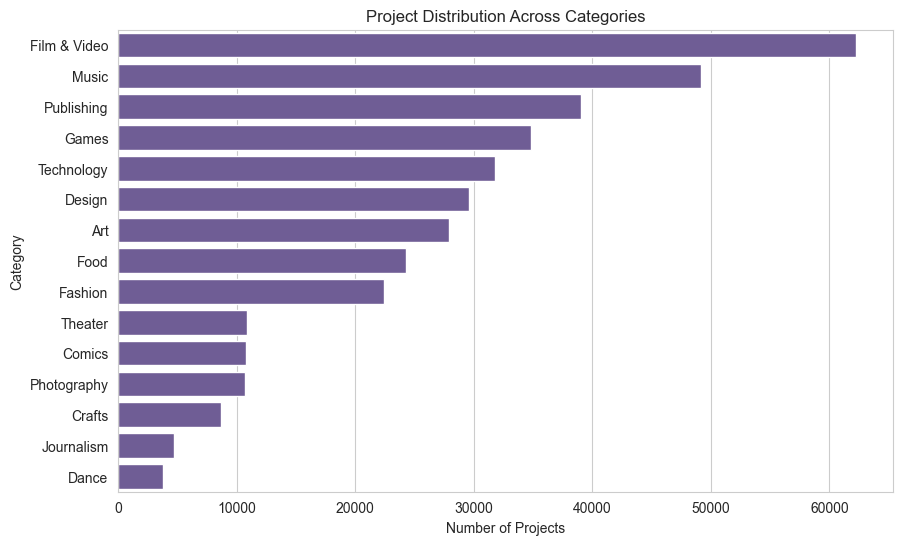

In [23]:
# Create a bar plot with custom color
plt.figure(figsize=(10, 6))
newdf2 = pd.DataFrame(df['Category'].value_counts().sort_values(ascending=False).reset_index())
sns.barplot(data=newdf2, y='Category', x='count', color=custom_colour)

# Customize the plot
plt.title('Project Distribution Across Categories')
plt.xlabel('Number of Projects')
plt.ylabel('Category')
plt.show()

<Axes: xlabel='count', ylabel='Subcategory'>

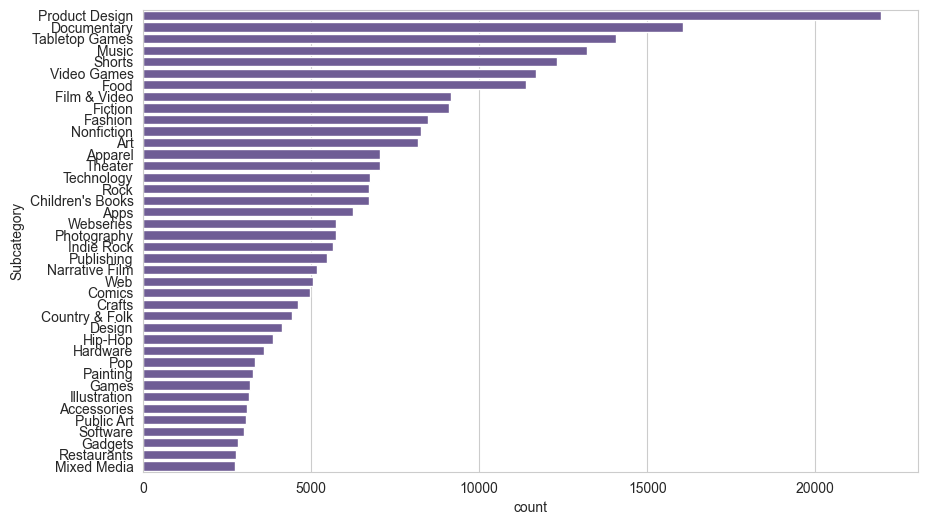

In [24]:
plt.figure(figsize=(10, 6))
newdf = pd.DataFrame(df['Subcategory'].value_counts().sort_values(ascending=False).reset_index())
sns.barplot(data=newdf.head(40), y='Subcategory', x='count', color=custom_colour)


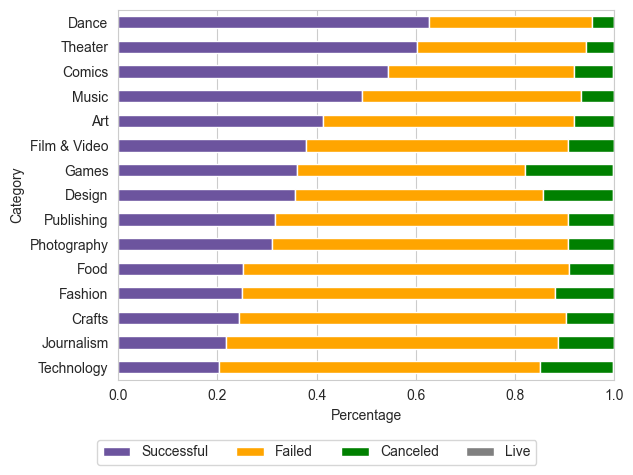

In [25]:
# Custom colour
green = (0/255, 128/255, 0/255)  # RGB(0, 128, 0)

# Calculate the percentage of projects in each state by category
state_counts = pd.crosstab(df['Category'], df['State'], normalize='index')

# Select and order the relevant columns for the 100% stacked bar chart
state_counts = state_counts[['Successful', 'Failed', 'Canceled', 'Live']].sort_values(by='Successful', ascending=True)

# Create a horizontal 100% stacked bar chart with custom colors
state_counts.plot(kind='barh', stacked=True, color=[custom_colour, orange, green, 'gray'])

# Set x-axis label, legend, x-axis limit, and y-axis ticks rotation
plt.xlabel('Percentage')
plt.legend(loc='lower center', bbox_to_anchor=(0.4, -0.25), ncol=5)
plt.xlim(0, 1)
plt.yticks(rotation=0)

# Display the plot
plt.show()

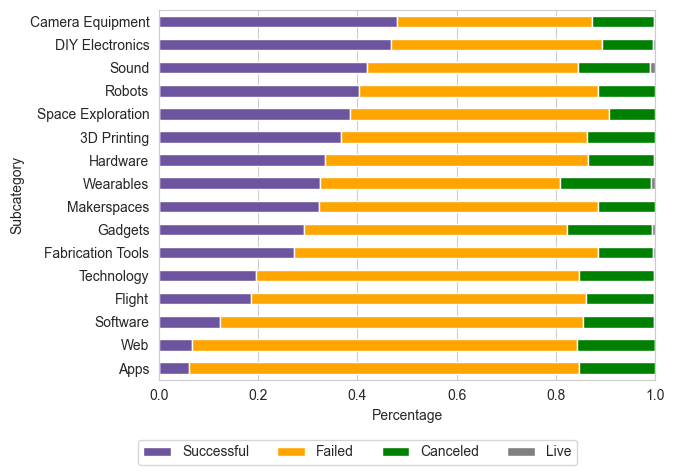

In [26]:
# Filter DataFrame for projects in the 'Technology' category
# You can uncomment the following line to further filter by launch year
# df_filtered = df[(df['Category'] == 'Technology') & (df['LaunchYear'] != 2017)]
df_filtered = df[(df['Category'] == 'Technology')]

# Calculate the percentage of projects in each state by subcategory
state_counts = pd.crosstab(df_filtered['Subcategory'], df_filtered['State'], normalize='index')

# Select and order the relevant columns for the 100% stacked bar chart
state_counts = state_counts[['Successful', 'Failed', 'Canceled', 'Live']].sort_values(by='Successful', ascending=True)

# Create a horizontal 100% stacked bar chart with custom colors
state_counts.plot(kind='barh', stacked=True, color=[custom_colour, orange, green, 'gray'])

# Set x-axis label, legend, x-axis limit, and y-axis ticks rotation
plt.xlabel('Percentage')
plt.legend(loc='lower center', bbox_to_anchor=(0.4, -0.25), ncol=5)
plt.xlim(0, 1)
plt.yticks(rotation=0)

# Display the plot
plt.show()

Observations:

- Certain categories, such as dance, theater, and comics, exhibit higher success rates compared to others.
- Larger categories, with more projects, tend to have lower success/cancellation rates, likely due to increased competition.
- The success rates of categories change over the years.
- When zooming into subcategories, significant differences in success rates can be observed, with some subcategories having a more balanced distribution.

Considerations:

- Decision on which column to drop needs to be made.
- Categories (`cat`) and subcategories (`subcat`) are strongly related, and one of them should be dropped.
- Encoding categorical columns can be approached in various ways:
  - One-Hot Encoding (OHE) would add 159 columns, resulting in sparse data but without introducing cardinal order.
  - Count Encoder assigns frequencies to categories, resulting in only one additional column but introducing cardinal order.

### Country

In [27]:
total_count = df['ID'].count()
country_counts = df.groupby('Country')['ID'].count().sort_values(ascending=False)
country_percents = (country_counts / total_count) * 100
print(country_percents)

Country
United States     78.222547
United Kingdom     8.974677
Canada             3.922796
Australia          2.074981
Germany            1.096980
France             0.777005
Netherlands        0.758389
Italy              0.750026
Spain              0.596513
Sweden             0.465394
Mexico             0.442731
New Zealand        0.384995
Denmark            0.292456
Ireland            0.214486
Switzerland        0.199377
Norway             0.187776
Belgium            0.161336
Austria            0.155941
Hong Kong          0.155131
Singapore          0.141642
Luxembourg         0.016457
Japan              0.008364
Name: ID, dtype: float64


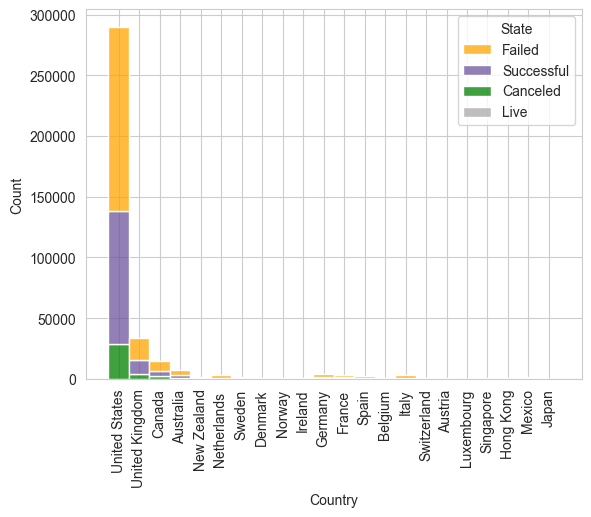

In [28]:
grey = (169/255, 169/255, 169/255)  # RGB(169, 169, 169)

# Plot histogram with custom colours
sns.histplot(data=df, x='Country', hue='State', multiple='stack', palette=[orange, custom_colour, green, grey])
plt.xticks(rotation=90)
plt.show()

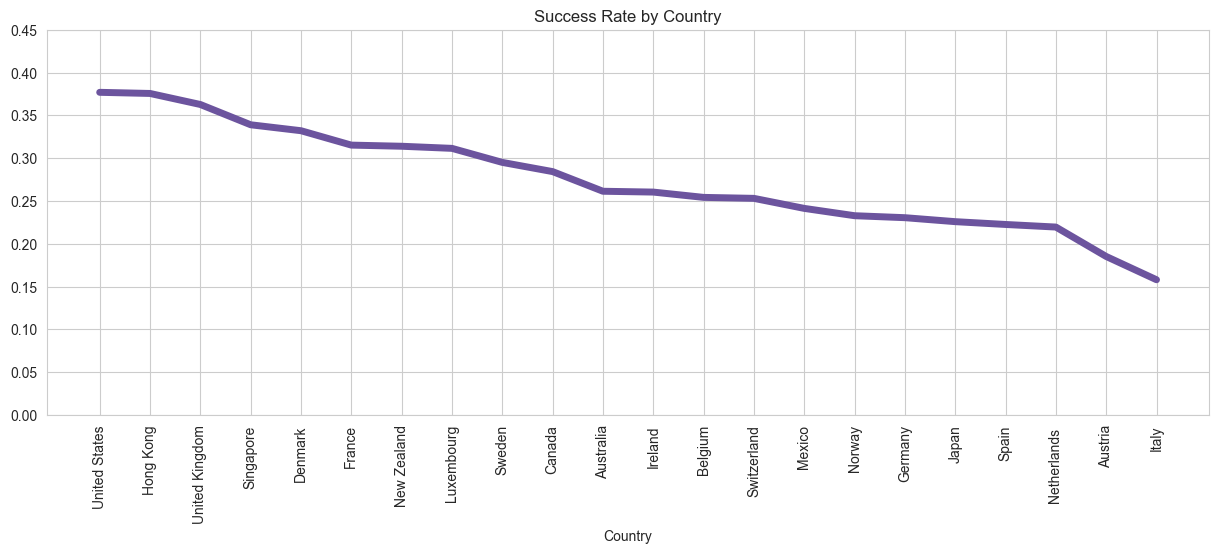

In [29]:
# Calculate success rate by country
success_rate = df[df['State'] == 'Successful'].groupby('Country').size() / df.groupby('Country').size()

# Sort success rate by descending order
success_rate = success_rate.sort_values(ascending=False)

# Plot success rate by country
plt.figure(figsize=(15, 5))
sns.lineplot(x=success_rate.index, y=success_rate.values, color=custom_colour, linewidth=5)
plt.xticks(rotation=90)
plt.title('Success Rate by Country')
plt.ylim(0, 0.45)
plt.show()

Observations:
- A significant majority of projects (over 78%) are situated in the United States, resulting in a considerable skew towards US-based projects in our dataset.
- Correspondingly, the success rate is notably highest in the US, exceeding 35%. Conversely, the lowest success rates are predominantly observed in European countries, averaging around 25%.

Considerations
- Considering the substantial skewness towards the US, there's contemplation about dropping the `Country` column altogether.
- Alternatively, an approach could involve creating two distinct columns: one for US and another for non-US projects.
- Further decisions will be made during the modeling phase based on the impact of these considerations.

### Backers

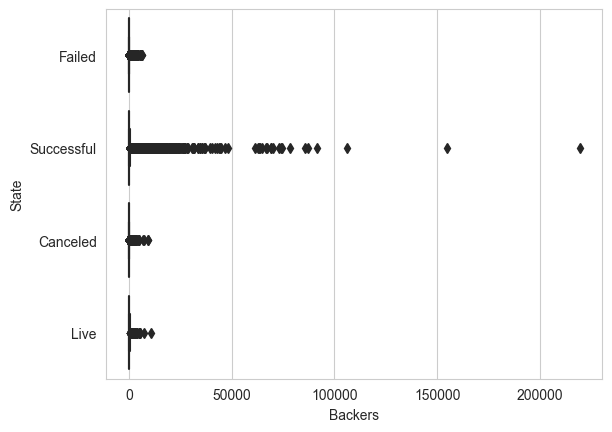

In [30]:
# Create a boxplot with custom colours
sns.boxplot(data=df, x='Backers', y='State', palette={'Successful': custom_colour, 'Failed': orange, 'Canceled': green, 'Live': grey})

# Display the plot
plt.show()


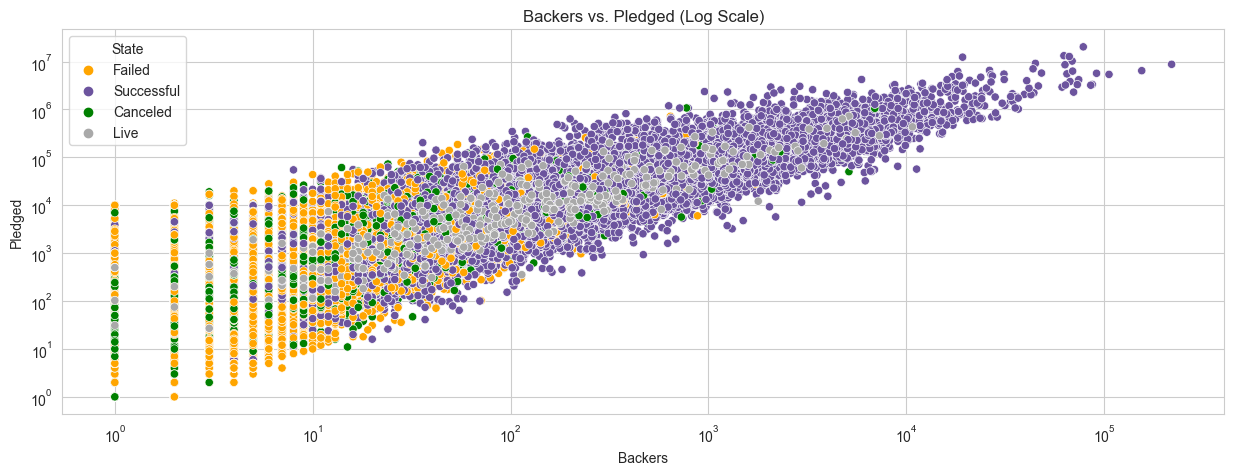

In [31]:
# Create a scatterplot with custom colours for each class of 'State'
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df, x='Backers', y='Pledged', hue='State', palette={'Successful': custom_colour, 'Failed': orange, 'Canceled': green, 'Live': grey})

# Uncomment the following lines to enable log scale on both axes
plt.xscale('log')
plt.yscale('log')

# Set the plot title
plt.title('Backers vs. Pledged (Log Scale)')

# Display the plot
plt.show()

<Axes: >

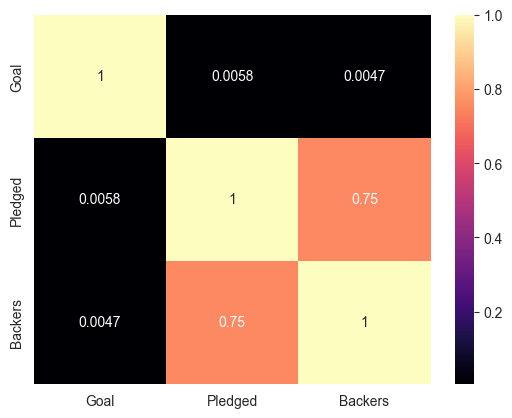

In [32]:
sns.heatmap(df[['Goal','Pledged','Backers']].corr(numeric_only=True), annot=True, cmap='magma')

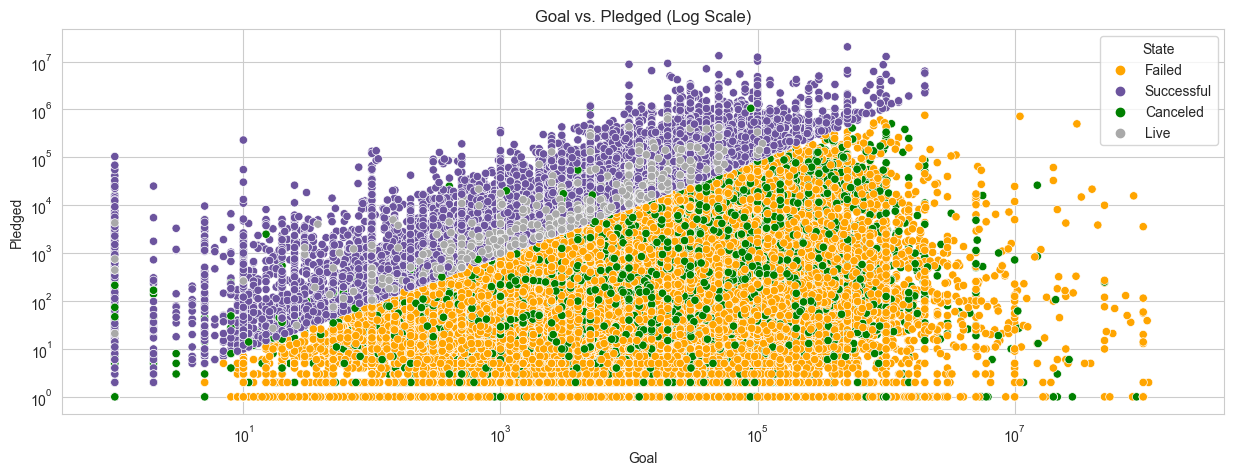

In [33]:
# Create a scatterplot with custom colours for each class of 'State'
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df, x='Goal', y='Pledged', hue='State', palette={'Successful': custom_colour, 'Failed': orange, 'Canceled': green, 'Live': grey})

# Uncomment the following lines to enable log scale on both axes
plt.xscale('log')
plt.yscale('log')

# Set the plot title
plt.title('Goal vs. Pledged (Log Scale)')

# Display the plot
plt.show()


Observations:
- There appears to be a linear correlation between the number of backers and the amount pledged.

Considerations:
- Predicting the number of backers might be a more feasible option than predicting the pledged amount.
- It is advisable to explore models that predict the number of backers.


### Model 1 - Predicting `Pledged`

In this phase of the project, our primary goal is to predict the pledged amount for Kickstarter projects. We are exploring various input features such as campaign duration, subcategory, goal, and launch date to understand their influence on the pledged amount.

#### Input Features

1. **Campaign Duration**
2. **Subcategory**
3. **Goal**
4. **Launch Date**

#### Baseline Models

To establish a foundation for our prediction task, we begin with the following baseline models:

1. **Dummy Regressor with Mean Strategy:**
   - This simplistic model considers the mean of the pledged amount as a benchmark. It provides a starting point for comparison and helps us understand the performance of more sophisticated models.

2. **Linear Regression with Only `Goal` as Feature:**
   - A linear regression model is implemented with the goal as the sole predictor. This basic model helps us gauge the impact of a single feature on the pledged amount.

#### Rationale

- **Choice of Dummy Regressor:** The Dummy Regressor with a mean strategy is chosen to establish a benchmark that represents the simplest possible prediction. It serves as a reference point for evaluating the effectiveness of more complex models.

- **Linear Regression with `Goal`:** This straightforward model with only the goal as a predictor allows us to explore the relationship between the campaign goal and the pledged amount. It helps us identify whether a linear relationship exists and if additional features are necessary for improved predictions.

#### Final Model

For the final model, we plan to implement the Random Forest Regressor. However, the primary focus at this stage is on understanding the dynamics of predicting the pledged amount, exploring the significance of different features, and setting the groundwork for more advanced models in subsequent iterations.


#### Feature Selection

In [34]:
columns_keepX = ['Duration', 'Subcategory', 'Goal', 'LaunchYear', 'LaunchMonth', \
                'LaunchDay', 'LaunchDayOfWeek']
columns_keepY = ['Pledged']

X = df[columns_keepX]
y = df[columns_keepY]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=X['Subcategory'])

#### Baseline Model

In [36]:
# Dummy Regressor
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_r2 = round(dummy.score(X_train, y_train), 2)
dummy_mse = round(mean_squared_error(y_train, dummy.predict(X_train), squared=False), 2)

print('For mean R2 score in the dummy model:', dummy_r2)
print('For mean RMSE score in the dummy model:', dummy_mse)


For mean R2 score in the dummy model: 0.0
For mean RMSE score in the dummy model: 92649.05


In [37]:
# Linear Regression
Xnew_train = pd.DataFrame(X_train['Goal'])
lr = LinearRegression()
lr.fit(Xnew_train, y_train)
lr_r2 = round(lr.score(Xnew_train, y_train), 2)
lr_rmse = round(mean_squared_error(y_train, lr.predict(Xnew_train), squared=False), 2)

print('Linear Regression R2 score:', lr_r2)
print('Linear Regression RMSE score:', lr_rmse)

Linear Regression R2 score: 0.0
Linear Regression RMSE score: 92647.68


In [38]:
# quick function to print main metrics of a model
def print_metrics(model_name, estimator, dummy, X_train, y_train, X_test, y_test):
    print(model_name.upper())
    print('Train R^2: {:.4f}'.format(estimator.score(X_train, y_train)))
    print('Train RMSE: {:.2f}'.format(mean_squared_error(y_train, estimator.predict(X_train), squared=False)))

    print('Test R^2: {:.4f}'.format(estimator.score(X_test, y_test)))
    print('Test RMSE: {:.2f}'.format(mean_squared_error(y_test, estimator.predict(X_test), squared=False)))
    print('Difference RMSE to Dummy: {:.2f}'.format(mean_squared_error(y_test, dummy.predict(X_test), squared=False) - \
                                                    mean_squared_error(y_test, estimator.predict(X_test), squared=False)))

    print('Dummy R^2: {:.4f}'.format(dummy.score(X_test, y_test)))
    print('Dummy RMSE: {:.2f}'.format(mean_squared_error(y_test, dummy.predict(X_test), squared=False)))


#### Feature Engineering

#### Pipeline Planning

In [39]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Subcategory'])
], remainder='passthrough')

pipeline_model = Pipeline([
    ('ct', ct),
    ('rf', RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1))
])

In [40]:
# pledged
pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Subcategory'])])),
                ('rf',
                 RandomForestRegressor(max_depth=10, n_jobs=-1,
                                       random_state=42))])

In [41]:
print_metrics('Random Forest Target Pledged', pipeline_model, dummy, X_train, y_train, X_test, y_test) 

RANDOM FOREST TARGET PLEDGED
Train R^2: 0.5780
Train RMSE: 60188.56
Test R^2: -0.0415
Test RMSE: 88884.88
Difference RMSE to Dummy: -1787.16
Dummy R^2: -0.0000
Dummy RMSE: 87097.73


### Model 2 - Predicting `Backers`
In this phase, our objective is to predict the number of backers a Kickstarter project will attract. We consider several input features, including campaign duration, subcategory, goal (pledged amount), and launch date.

#### Input Features

1. **Campaign Duration**
2. **Subcategory**
3. **Goal (Pledged Amount)**
4. **Launch Date**

#### Baseline Models

To establish a baseline for predicting the number of backers, we employ the following models:

1. **Dummy Regressor with Mean Strategy (Dummy2):**
   - This dummy regressor predicts the mean number of backers for all projects. It provides a starting point for assessing the performance of more sophisticated models.

#### Final Models

For the final models, we explore two different regressors:

1. **Random Forest Regressor:**
   - A random forest regressor is employed to capture non-linear relationships and complexities within the data.

2. **XGBoost Regressor:**
   - The XGBoost regressor is another ensemble learning model that excels in capturing intricate patterns and relationships in the data.

#### Rationale

- **Choice of Dummy Regressor:** Similar to the previous model, the Dummy Regressor with a mean strategy is chosen to create a baseline for comparison. Its negative R2 score and MSE help us appreciate the performance improvements achieved by more sophisticated models.

- **Random Forest and XGBoost Regressors:** These ensemble models are selected for their ability to handle complex relationships and patterns within the data. Their performance metrics, including R2 score and MSE, will be assessed to determine the effectiveness of predicting the number of backers.

#### Conclusion

While presenting the results, the emphasis is on understanding the dynamics of predicting backers and assessing the impact of different features on the outcome.


#### Feature Selection

In [42]:
columns_keepX2 = ['Duration', 
                  'Subcategory', 
                  'Goal', 
                  'LaunchYear', 
                 'LaunchMonth',
                'LaunchDay', 
                'LaunchDayOfWeek', 
                'Pledged'
                ]
columns_keepY2 = ['Backers']

# df2 = df[df['Pledged'] >= df['Goal']]
# df = df.copy()
# df = df[df['State'] == 'Successful']
X2 = df[columns_keepX2]
y2 = df[columns_keepY2]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)


#### Baseline Model

In [43]:
# Dummy Regressor 2
dummy2 = DummyRegressor(strategy='mean')
dummy2.fit(X2_train, y2_train)
dummy2_r2 = round(dummy2.score(X2_test, y2_test), 2)
dummy2_mse = round(mean_squared_error(y2_test, dummy2.predict(X2_test), squared=False), 2)

print('R2 of Dummy2:', dummy2_r2)
print('MSE of Dummy2:', dummy2_mse)


R2 of Dummy2: -0.0
MSE of Dummy2: 847.62


#### Pipeline Planning

In [44]:
# using column transformer from model 1
pipeline_model2 = Pipeline([
    ('ct', ct), # from Model 1, no changes (for now)
    ('rf', RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1))
])

#### Training the Model

In [45]:
# backers
pipeline_model2.fit(X2_train, y2_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Subcategory'])])),
                ('rf',
                 RandomForestRegressor(max_depth=10, n_jobs=-1,
                                       random_state=42))])

In [46]:
print_metrics('Random Forest Target Backers', pipeline_model2, dummy2, X2_train, y2_train, X2_test, y2_test)

RANDOM FOREST TARGET BACKERS
Train R^2: 0.9181
Train RMSE: 266.62
Test R^2: 0.7512
Test RMSE: 422.77
Difference RMSE to Dummy: 424.85
Dummy R^2: -0.0000
Dummy RMSE: 847.62


In [47]:
pipeline_model3 = Pipeline([
    ('ct', ct),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1, enable_categorical=True))
])

In [48]:
pipeline_model3.fit(X2_train, y2_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Subcategory'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=True...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [49]:
print_metrics('XGBoost for Backers', pipeline_model3, dummy2, X2_train, y2_train, X2_test, y2_test)

XGBOOST FOR BACKERS
Train R^2: 0.9174
Train RMSE: 267.71
Test R^2: 0.4603
Test RMSE: 622.69
Difference RMSE to Dummy: 224.93
Dummy R^2: -0.0000
Dummy RMSE: 847.62


In [50]:
# print_metrics('Random Tree for Pledged', pipeline_model, dummy, X_train, y_train, X_test, y_test)
print_metrics('Random Tree for Backers', pipeline_model2, dummy2, X2_train, y2_train, X2_test, y2_test)
print_metrics('XGBoost for Backers', pipeline_model3, dummy2, X2_train, y2_train, X2_test, y2_test)

RANDOM TREE FOR BACKERS
Train R^2: 0.9181
Train RMSE: 266.62
Test R^2: 0.7512
Test RMSE: 422.77
Difference RMSE to Dummy: 424.85
Dummy R^2: -0.0000
Dummy RMSE: 847.62
XGBOOST FOR BACKERS
Train R^2: 0.9174
Train RMSE: 267.71
Test R^2: 0.4603
Test RMSE: 622.69
Difference RMSE to Dummy: 224.93
Dummy R^2: -0.0000
Dummy RMSE: 847.62


#### Model Optimization

#### XGBoost Optimization

In [52]:
pipeline_model3.get_params();

In [53]:
param_grid = {
    # # Specify the booster type, which can be 'gbtree', 'gblinear', or 'dart'.
    'xgb__booster': ['gbtree', 'gblinear', 'dart'], #from pipline element: ('xgb', XGBRegressor(random_state=42, n_jobs=-1, enable_categorical=True))

    # # Enable or disable categorical feature support.
    'xgb__enable_categorical': [True, False],

    # # Fraction of features to be randomly sampled for each tree.
    'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],

    # # Step size shrinkage to prevent overfitting.
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3],

    # # Maximum depth of a tree. Controls the maximum depth of each tree in the ensemble.
    'xgb__max_depth': [3, 4, 5, 6, 7, 8, 9],

    # # Number of boosting rounds (trees) to be run.
    'xgb__n_estimators': [50, 100, 200, 300, 400],
}


In [54]:
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline_model3,
    param_distributions=param_grid,
    n_iter=10,  # Number of random parameter combinations to try
    cv=5,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1,  # Use -1 to use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

In [55]:
# Fit the RandomizedSearchCV object to your data
random_search.fit(X2_train, y2_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", -random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/stevenschepanski/Documents/Projects/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stevenschepanski/Documents/Projects/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stevenschepanski/Documents/Projects/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stevenschepanski/Documents/Projects/.venv/lib/python3.11/site-package

KeyboardInterrupt: 

In [ ]:
# visualize residuals
y_pred = pipeline_model2.predict(X2_test)
y_pred.max()
display = PredictionErrorDisplay(y_true=y2_test, y_pred=y_pred.reshape(-1, 1))
display.plot()

#### Random Forest Optimization

In [68]:
cf2 = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Subcategory']),
    ('scale', RobustScaler(), ['Pledged'])
], remainder='passthrough')

pipeline_model4 = Pipeline([
    ('cf', cf2),
    ('rt', RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1))
])

In [69]:
pipeline_model4.fit(X2_train, y2_train)

Pipeline(steps=[('cf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Subcategory']),
                                                 ('boxcox', RobustScaler(),
                                                  ['Pledged'])])),
                ('rt',
                 RandomForestRegressor(max_depth=10, n_jobs=-1,
                                       random_state=42))])

In [53]:
# print_metrics('Random Tree for Pledged', pipeline_model, dummy, X_train, y_train, X_test, y_test)
print_metrics('Random Forest for Backers', pipeline_model2, dummy2, X2_train, y2_train, X2_test, y2_test)
print_metrics('XGBoost for Backers', pipeline_model3, dummy2, X2_train, y2_train, X2_test, y2_test)
print_metrics('Random Forest for Backers Scaled Pledged', pipeline_model4, dummy2, X2_train, y2_train, X2_test, y2_test)

NameError: name 'pipeline_model2' is not defined

In [71]:
pipeline_model4.get_params()

{'memory': None,
 'steps': [('cf', ColumnTransformer(remainder='passthrough',
                     transformers=[('ohe',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Subcategory']),
                                   ('boxcox', RobustScaler(), ['Pledged'])])),
  ('rt', RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42))],
 'verbose': False,
 'cf': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['Subcategory']),
                                 ('boxcox', RobustScaler(), ['Pledged'])]),
 'rt': RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42),
 'cf__n_jobs': None,
 'cf__remainder': 'passthrough',
 'cf__sparse_threshold': 0.3,


In [109]:
param_grid = {
              'rt__max_depth': range(5, 100, 10),
              'rt__n_estimators': range(100, 1000, 100),
              'rt__max_features': [1, 'sqrt'],
              'rt__criterion': ['absolute_error'],
              'rt__max_samples': [0.5, 0.75, 1.0],
              }
rs2 = RandomizedSearchCV(
    estimator=pipeline_model4,
    param_distributions=param_grid,
    n_iter=100,  # Number of random parameter combinations to try
    cv=5,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1,  # Use -1 to use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

In [ ]:
rs2.fit(X2_train, y2_train)

In [1]:
rs2.best_params_


NameError: name 'rs2' is not defined

# Conclusion